In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers
from tensorflow.keras.callbacks import TensorBoard

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

print(tf.__version__)

2.3.0


In [2]:
image_size = (96, 96)  # default is (256, 256), smaller is faster training
batch_size = 32   # default is 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data_color",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data_color",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
)

for images, labels in train_ds.take(1):
    print(images[0].shape)

Found 519 files belonging to 4 classes.
Using 416 files for training.
Found 519 files belonging to 4 classes.
Using 103 files for validation.
(96, 96, 1)


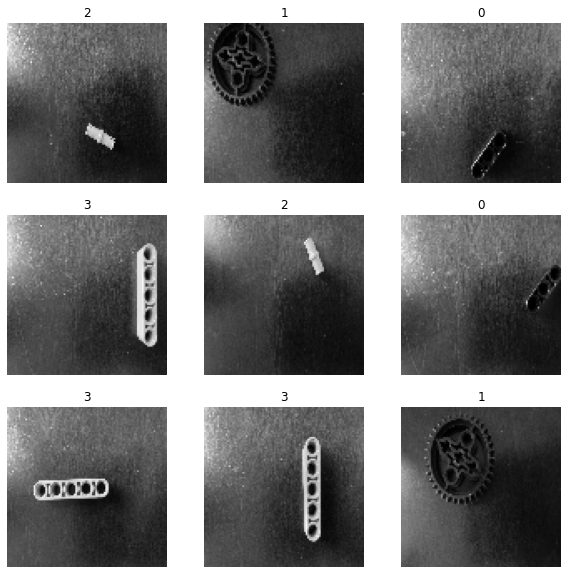

In [3]:
# displaying the training data

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
        plt.title(int(labels[i]))
        plt.axis("off")

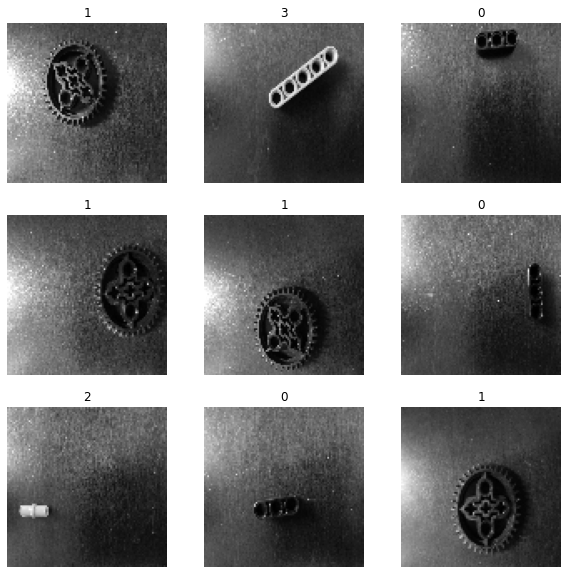

In [4]:
# displaying the validation data

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.regularizers import l2

#define model
def resnet_v1_eembc():
    # Resnet parameters
    input_shape=[128,128,1] # default size for cifar10
    num_classes=10 # default class number for cifar10
    num_filters = 64 # this should be 64 for an official resnet model

    # Input layer, change kernel size to 7x7 and strides to 2 for an official resnet
    inputs = Input(shape=input_shape)
    x = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x) # uncomment this for official resnet model


    # First stack

    # Weight layers
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(y)
    y = BatchNormalization()(y)

    # Overall residual, connect weight layer and identity paths
    x = tf.keras.layers.add([x, y])
    x = Activation('relu')(x)


    # Second stack

    # Weight layers
    num_filters = 32 # Filters need to be double for each stack
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(y)
    y = BatchNormalization()(y)

    # Adjust for change in dimension due to stride in identity
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)

    # Overall residual, connect weight layer and identity paths
    x = tf.keras.layers.add([x, y])
    x = Activation('relu')(x)


    # Third stack

    # Weight layers
    num_filters = 64
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(num_filters,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(y)
    y = BatchNormalization()(y)

    # Adjust for change in dimension due to stride in identity
    x = Conv2D(num_filters,
                  kernel_size=1,
                  strides=2,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))(x)

    # Overall residual, connect weight layer and identity paths
    x = tf.keras.layers.add([x, y])
    x = Activation('relu')(x)


    # Fourth stack.
    # While the paper uses four stacks, for cifar10 that leads to a large increase in complexity for minor benefits
    # Uncomments to use it

#    # Weight layers
#    num_filters = 128
#    y = Conv2D(num_filters,
#                  kernel_size=3,
#                  strides=2,
#                  padding='same',
#                  kernel_initializer='he_normal',
#                  kernel_regularizer=l2(1e-4))(x)
#    y = BatchNormalization()(y)
#    y = Activation('relu')(y)
#    y = Conv2D(num_filters,
#                  kernel_size=3,
#                  strides=1,
#                  padding='same',
#                  kernel_initializer='he_normal',
#                  kernel_regularizer=l2(1e-4))(y)
#    y = BatchNormalization()(y)
#
#    # Adjust for change in dimension due to stride in identity
#    x = Conv2D(num_filters,
#                  kernel_size=1,
#                  strides=2,
#                  padding='same',
#                  kernel_initializer='he_normal',
#                  kernel_regularizer=l2(1e-4))(x)
#
#    # Overall residual, connect weight layer and identity paths
#    x = tf.keras.layers.add([x, y])
#    x = Activation('relu')(x)


    # Final classification layer.
    pool_size = int(np.amin(x.shape[1:3]))
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
model_id = "complex"

if model_id == "complex" :  
    model = tf.keras.Sequential([
        Input(shape=image_size + (1,)),
        layers.Conv2D(16, kernel_size=(3,3), activation="relu", padding='same', strides=(2,2)),
        layers.Conv2D(32, kernel_size=(4,4), activation="relu", padding='same', strides=(2,2)),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
        layers.Conv2D(16, kernel_size=(3,3), activation="relu", padding='same', strides=(2,2)),
        layers.MaxPooling2D(pool_size=(2, 2),  strides=(2,2)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        #layers.Dropout(0.5),
        layers.Dense(4),
        layers.Softmax(),
    ], name="complex_cnn")
elif model_id == "complex2":
    model = tf.keras.Sequential([
        Input(shape=image_size + (3,)),
        layers.Conv2D(32, kernel_size=(3,3), activation="relu", padding='same', strides=(2,2)),
        layers.Conv2D(64, kernel_size=(3,3), activation="relu", padding='same', strides=(2,2)),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),    
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(10),
        #layers.Softmax(),
    ], name="complex2_cnn")
else :
    model = resnet_v1_eembc()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "complex_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        8224      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 16)          4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 16)          64        
_________________________________________________________________
flatten (Flatten)            (None, 144)               

In [7]:
epochs = 25

#callbacks = [keras.callbacks.ModelCheckpoint("project_model_epoch_50.h5"),]

#name = "cnn-conv-max-x3-stride2-{}".format(int(time.time()))
#tensorboard = TensorBoard(log_dir='logs/{}'.format(name), profile_batch=0)
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=2)

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],)

train_hist = model.fit(train_ds,
                       epochs=epochs, 
                       callbacks=callbacks,
                       validation_data=val_ds,
                       workers=6,)

#train_hist = model.fit(train_images, train_labels, epochs=50)
#model.save('model')

Epoch 1/25
13/13 [==============================] - 9s 692ms/step - loss: 1.2325 - accuracy: 0.5361 - val_loss: 1.4280 - val_accuracy: 0.3107
Epoch 2/25
13/13 [==============================] - 9s 683ms/step - loss: 1.0388 - accuracy: 0.7716 - val_loss: 1.3682 - val_accuracy: 0.3204
Epoch 3/25
13/13 [==============================] - 9s 671ms/step - loss: 0.9485 - accuracy: 0.8750 - val_loss: 1.4247 - val_accuracy: 0.2621
Epoch 4/25
13/13 [==============================] - 9s 663ms/step - loss: 0.8849 - accuracy: 0.9255 - val_loss: 1.3554 - val_accuracy: 0.3883
Epoch 5/25
13/13 [==============================] - 9s 664ms/step - loss: 0.8408 - accuracy: 0.9543 - val_loss: 1.1996 - val_accuracy: 0.5146
Epoch 6/25
13/13 [==============================] - 9s 666ms/step - loss: 0.8026 - accuracy: 0.9808 - val_loss: 1.1053 - val_accuracy: 0.5825
Epoch 7/25
13/13 [==============================] - 9s 672ms/step - loss: 0.7825 - accuracy: 0.9904 - val_loss: 1.0497 - val_accuracy: 0.6699
Epoch 

In [8]:
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import img_to_array

image_size = (96, 96)
batch_size = 32

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "test_data",
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    seed=1337,
    image_size=image_size,
    shuffle=False,
)

Found 93 files belonging to 4 classes.


Using TensorFlow backend.


In [9]:
# displaying the validation data

label_array = [[],[],[],[]]
pred_label_array = [[],[],[],[]]
test_images = []

counter_label = 0
counter_image = 0
prev_label = 0

for images, labels in test_ds:
    for label in labels:
        if int(label) != prev_label:
            counter_label = 0
        label_array[int(label)].append(int(label))
        counter_label += 1
        prev_label = int(label)
    for image in images:
        test_images.append(image)
        counter_image += 1
        
#print(label_array,"\n")

samples_to_predict = np.array(test_images)
#print(samples_to_predict.shape)

predictions = model.predict(samples_to_predict)
# print(predictions)

classes = np.argmax(predictions, axis = 1)
#print(classes)

# test accuracy
accuracy = 0
counter = 0

for i in range(4):
    for j in range(len(label_array[i])):
        if classes[counter] == label_array[i][j]:
            accuracy += 1
        pred_label_array[i].append(classes[counter])
        counter += 1

label_names = ["black_3_holes", "black_wheel", "grey_2_studs", "grey_5_holes"]       
        
for i in range(4):
    print(label_names[i])
    print(label_array[i])
    print(pred_label_array[i], "\n")
        
#for i in range(len(classes)):
#    if classes[i] == label_array[i]:
#        accuracy += 1

accuracy = accuracy/len(classes)

print("test accuracy: ", accuracy)       

black_3_holes
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

black_wheel
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 

grey_2_studs
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2] 

grey_5_holes
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3] 

test accuracy:  0.967741935483871


# Quantize and Convert to TFLite

In [10]:
#model.save('keras_model2')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file('keras_model2')

converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [11]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
  for _ in range(num_calibration_steps):
    next_input = next(ds_iter)[0]
    next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
    yield [next_input]

In [12]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter.inference_output_type = tf.int8  # or tf.uint8

In [13]:
tflite_quant_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\Dylan\AppData\Local\Temp\tmp72yqo65x\assets


In [14]:
fname = 'kws_model1.tflite'
with open(fname, "wb") as fpo:
  num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

Wrote 40352 / 40352 bytes to tflite file
